Предсказание оттока полльзователей

https://www.kaggle.com/c/advanced-dls-fall-2020

In [20]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder, FunctionTransformer
from sklearn.pipeline import make_pipeline, FeatureUnion
from sklearn import pipeline
%matplotlib inline

In [2]:
data = pd.read_csv('./train.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5282 non-null   int64  
 1   MonthlySpending           5282 non-null   float64
 2   TotalSpent                5282 non-null   object 
 3   Sex                       5282 non-null   object 
 4   IsSeniorCitizen           5282 non-null   int64  
 5   HasPartner                5282 non-null   object 
 6   HasChild                  5282 non-null   object 
 7   HasPhoneService           5282 non-null   object 
 8   HasMultiplePhoneNumbers   5282 non-null   object 
 9   HasInternetService        5282 non-null   object 
 10  HasOnlineSecurityService  5282 non-null   object 
 11  HasOnlineBackup           5282 non-null   object 
 12  HasDeviceProtection       5282 non-null   object 
 13  HasTechSupportAccess      5282 non-null   object 
 14  HasOnlin

In [4]:
# Числовые признаки
num_cols = [
    'ClientPeriod',
    'MonthlySpending',
    'TotalSpent'
]

# Категориальные признаки
cat_cols = [
    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]

feature_cols = num_cols + cat_cols
target_col = 'Churn'

In [6]:
data.sample(10)

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
2551,71,111.25,7984.15,Female,0,No,No,Yes,Yes,Fiber optic,No,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Electronic check,0
535,64,89.45,5692.65,Male,0,Yes,No,Yes,Yes,Fiber optic,Yes,Yes,Yes,No,No,No,One year,No,Bank transfer (automatic),0
1854,8,92.10,729.95,Female,1,No,No,Yes,No,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,1
4734,55,60.00,3316.1,Male,1,Yes,No,Yes,Yes,DSL,Yes,Yes,No,No,No,No,One year,No,Credit card (automatic),0
895,12,20.05,267,Male,0,No,No,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Credit card (automatic),0
4764,23,24.35,538.5,Male,0,Yes,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,0
2269,1,44.45,44.45,Female,0,No,No,Yes,No,DSL,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,1
3023,71,24.65,1766.75,Male,1,No,No,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,Yes,Mailed check,0
1143,72,90.15,6716.45,Female,1,Yes,Yes,Yes,Yes,DSL,Yes,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),0
982,1,45.55,45.55,Male,0,No,No,Yes,No,DSL,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,0


Проверим наличие NaN в датасете:

In [7]:
data.isna().values.any()

False

Как мы видим, тип данных в столбце TotalSpent имеет тип object

In [8]:
data[num_cols].dtypes

ClientPeriod         int64
MonthlySpending    float64
TotalSpent          object
dtype: object

Глянем на значения в столбце:

In [9]:
data['TotalSpent'].value_counts()

20.2       9
           9
19.75      8
20.05      6
19.65      6
          ..
1210.3     1
1270.25    1
118.4      1
3460.3     1
1152.8     1
Name: TotalSpent, Length: 4978, dtype: int64

Заменим пробелы на нули

In [10]:
mask = data.TotalSpent == ' '
data.loc[mask, 'TotalSpent'] = 0

Кастанем столбец к флоату

In [11]:
data.TotalSpent = data.TotalSpent.astype('float64')

Теперь заменим нули, которые мы вставили на место пробелов на среднее значение (мне кажется, это будет более реалистично, чем оставить нули, тк суммарные траты не могли быть равными нулю)

In [12]:
mask = data.TotalSpent == 0
data.loc[mask, 'TotalSpent'] = data.TotalSpent.mean()

In [13]:
data['TotalSpent'].value_counts()

20.200000      9
2287.486161    9
19.750000      8
19.650000      6
20.050000      6
              ..
990.450000     1
4144.800000    1
116.650000     1
2659.450000    1
150.000000     1
Name: TotalSpent, Length: 4978, dtype: int64

Построим гистограммы для численных признаков:

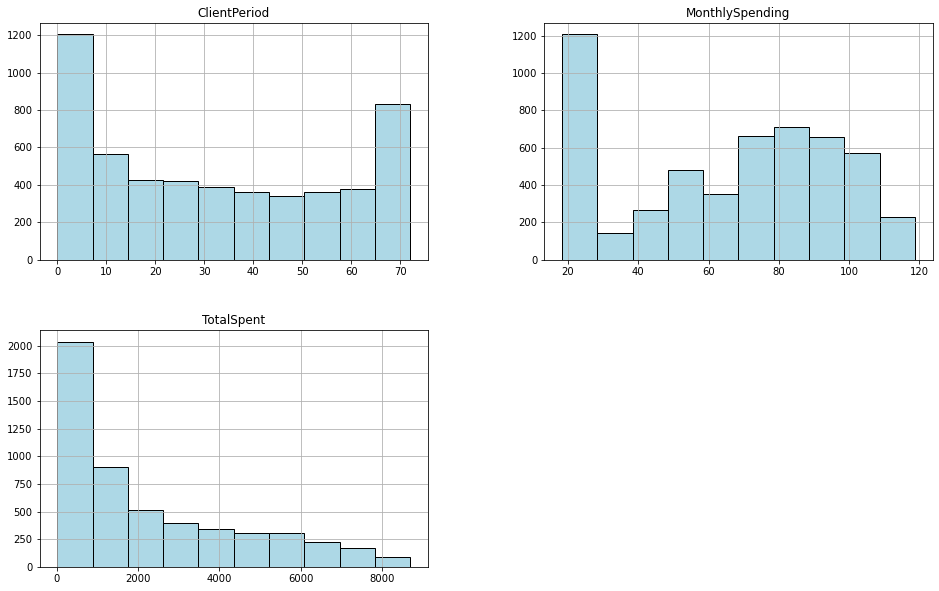

In [14]:
data[num_cols].hist(figsize=(16, 10), edgecolor='k', color='lightblue');

Для категориальных признаков посчитаем количество каждого значения для каждого признака:

In [15]:
for cat in cat_cols:
    print(data[cat].value_counts(), end='\n\n')

Male      2655
Female    2627
Name: Sex, dtype: int64

0    4440
1     842
Name: IsSeniorCitizen, dtype: int64

No     2705
Yes    2577
Name: HasPartner, dtype: int64

No     3676
Yes    1606
Name: HasChild, dtype: int64

Yes    4761
No      521
Name: HasPhoneService, dtype: int64

No                  2511
Yes                 2250
No phone service     521
Name: HasMultiplePhoneNumbers, dtype: int64

Fiber optic    2341
DSL            1800
No             1141
Name: HasInternetService, dtype: int64

No                     2612
Yes                    1529
No internet service    1141
Name: HasOnlineSecurityService, dtype: int64

No                     2332
Yes                    1809
No internet service    1141
Name: HasOnlineBackup, dtype: int64

No                     2317
Yes                    1824
No internet service    1141
Name: HasDeviceProtection, dtype: int64

No                     2604
Yes                    1537
No internet service    1141
Name: HasTechSupportAccess, dtype: in

Построим круговые диаграмы:

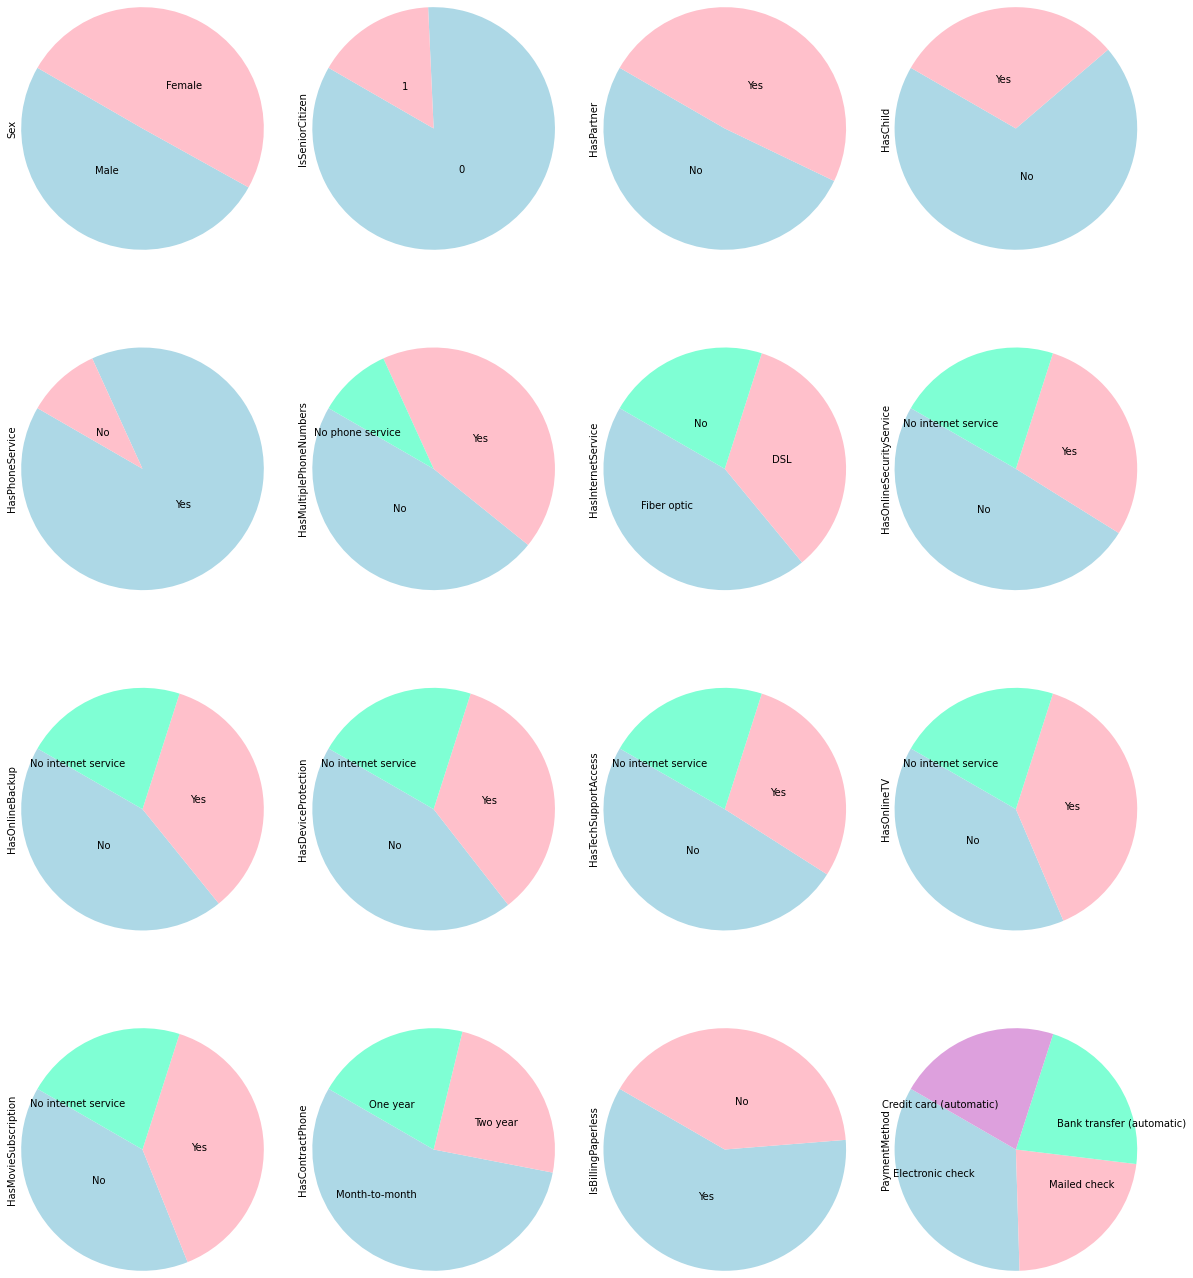

In [16]:
colors = ['lightblue', 'pink', 'aquamarine', 'plum']
fig, axes = plt.subplots(4, 4, figsize = (20, 24))
pos = 0
for cat in cat_cols:
    data[cat].value_counts().plot(
        kind='pie', labels=data[cat].value_counts().index, colors=colors, 
        ax=axes[pos//4, pos%4], startangle = 150, labeldistance=0.4, radius=1.25)
    pos += 1

Посмотрим на распределение целевой переменной

In [17]:
data[target_col].value_counts()

0    3898
1    1384
Name: Churn, dtype: int64

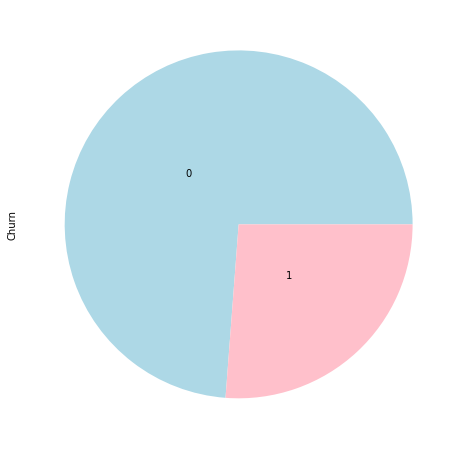

In [18]:
data[target_col].value_counts().plot(kind='pie', colors=colors, figsize=(12,8), labeldistance=0.4);

Дисбаланс есть, но не очень сильный.

Построим попарные зависимости вещественных признаков

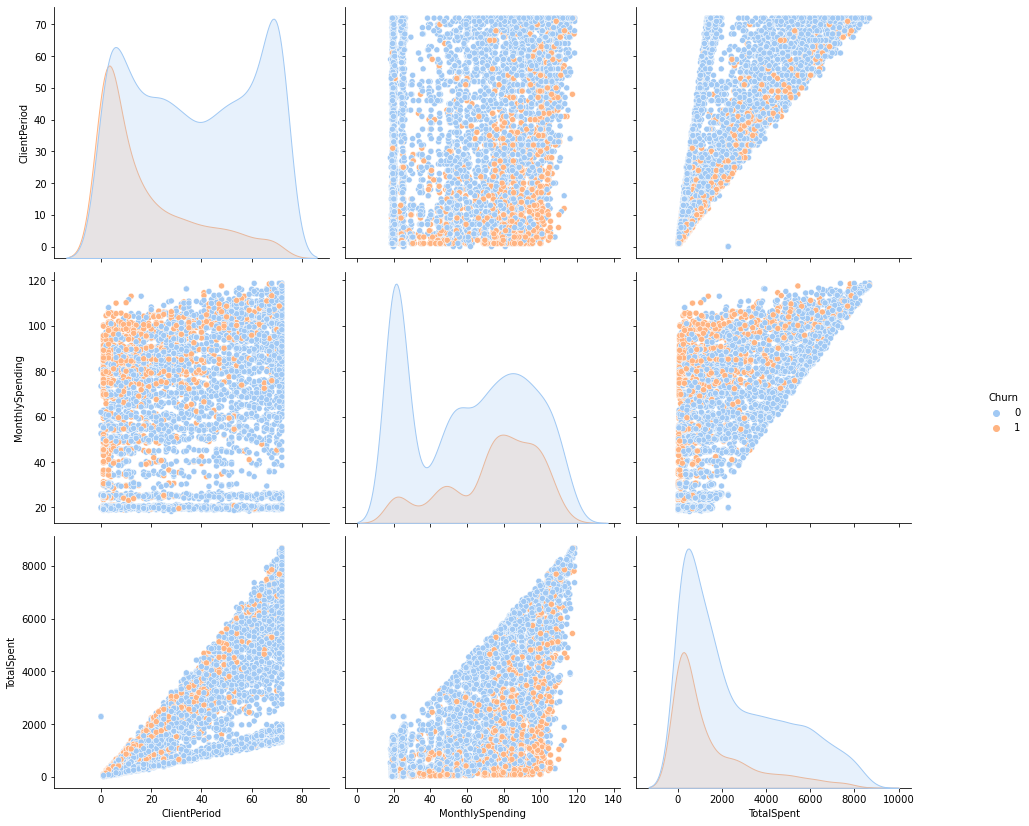

In [19]:
s = sns.pairplot(data[num_cols+['Churn']], hue='Churn', palette='pastel')
s.fig.set_figwidth(15)
s.fig.set_figheight(12)

В качестве baseline возьмем Логистическую регрессию.

In [21]:
X = data.drop('Churn', axis=1)
y = data['Churn']
# создадим булевые вектора для вещественных и категориальных признаков, где True будет в позициях нужных столбцов.
numeric_data_indices = np.array([(column in num_cols) for column in X.columns], dtype = bool)
categorical_data_indices = np.array([(column in cat_cols) for column in X.columns], dtype = bool)

In [22]:
logreg = LogisticRegression(max_iter=100000) 

Создадим пайплайн, где будем отдельно обрабатывать категориальные и вещественные признаки. Вещественные масштабировать, категориальные кодировать с помощью OHE. Данные разобьем и склеим с помощью FeatureUnion

In [23]:
estimator = pipeline.Pipeline(steps = [       
    ('feature_processing', pipeline.FeatureUnion(transformer_list = [        
            #numeric
            ('numeric_variables_processing', pipeline.Pipeline(steps = [
                ('selecting', FunctionTransformer(lambda data: data.iloc[:, numeric_data_indices])),
                ('scaling', StandardScaler(with_mean = 0))            
                        ])),
            #categorical
            ('categorical_variables_processing', pipeline.Pipeline(steps = [
                ('selecting', FunctionTransformer(lambda data: data.iloc[:, categorical_data_indices])),
                ('hot_encoding', OneHotEncoder(handle_unknown = 'ignore'))            
                        ])),
        ])),
    ('model_fitting', logreg)
    ]
)

Подберем лучший параметр C с помощью GridSearchCV

In [24]:
lr_parameters_grid = {'model_fitting__C': [100, 10, 1, 0.1, 0.01, 0.001]}
lr_grid = GridSearchCV(estimator, lr_parameters_grid, cv=5, scoring='roc_auc').fit(X, y)

In [25]:
lr_grid.best_params_

{'model_fitting__C': 100}

In [26]:
lr_grid.best_score_

0.8449832151169498

Лучшее качество на кроссвалидации - ROC-AUC = 0.845, С=100

Модель на первый взгляд получилась довольно хорошая, попробуем загрузить её на каггл фо фан.

In [28]:
test_data = pd.read_csv('test.csv')

In [29]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1761 entries, 0 to 1760
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              1761 non-null   int64  
 1   MonthlySpending           1761 non-null   float64
 2   TotalSpent                1761 non-null   object 
 3   Sex                       1761 non-null   object 
 4   IsSeniorCitizen           1761 non-null   int64  
 5   HasPartner                1761 non-null   object 
 6   HasChild                  1761 non-null   object 
 7   HasPhoneService           1761 non-null   object 
 8   HasMultiplePhoneNumbers   1761 non-null   object 
 9   HasInternetService        1761 non-null   object 
 10  HasOnlineSecurityService  1761 non-null   object 
 11  HasOnlineBackup           1761 non-null   object 
 12  HasDeviceProtection       1761 non-null   object 
 13  HasTechSupportAccess      1761 non-null   object 
 14  HasOnlin

Проведем все те же манипуляции со столбцом TotalSpent в тестовых данных

In [30]:
mask = test_data.TotalSpent == ' '
test_data.loc[mask, 'TotalSpent'] = 0

In [31]:
test_data.TotalSpent = test_data.TotalSpent.astype('float64')

In [32]:
mask = test_data.TotalSpent == 0
test_data.loc[mask, 'TotalSpent'] = test_data.TotalSpent.mean()

Сделаем предсказание и отправим его на каггл.

In [34]:
submission = pd.read_csv('./submission.csv')
submission['Churn'] =  lr_grid.best_estimator_.predict_proba(test_data)[:, 1]
submission.to_csv('./my_submission.csv', index=False)

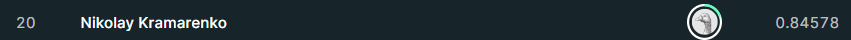

Очень неплохо для обычной логистической регрессии, даже без добавления доп признаков и подбором всего 1 параметра на гридсерче.

## Теперь примененим градиентный бустинг

Буду использовать catboost, поэтому не надо кодировать категориальные признаки, catboost сделает это сам.

In [35]:
import catboost

In [36]:
X_train, X_test, y_train, y_test  = train_test_split(data.drop('Churn', axis=1), data['Churn'], test_size=0.8)

In [37]:
cat = catboost.CatBoostClassifier(cat_features=cat_cols).fit(X_train, y_train, silent=True)

In [38]:
cat_roc = roc_auc_score(y_test, cat.predict_proba(X_test)[:, 1])
cat_roc

0.8367665985852767

Неплохо для базы, но хуже нашего магического логрега =)
Попробуем подобрать параметры.

In [39]:
params_grid = {'learning_rate': [0.08, 0.1, 0.2],
        'depth': [2, 3, 4],
        'n_estimators': [150, 200, 250]}

In [43]:
%%time
cat = catboost.CatBoostClassifier(cat_features=cat_cols)
grid_search_result = cat.grid_search(params_grid, 
                                       X=X_train, 
                                       y=y_train, 
                                       verbose=False)


bestTest = 0.424982822
bestIteration = 148


bestTest = 0.4281415638
bestIteration = 144


bestTest = 0.4292714541
bestIteration = 96


bestTest = 0.4311975998
bestIteration = 196


bestTest = 0.4214383663
bestIteration = 198


bestTest = 0.4270951223
bestIteration = 119


bestTest = 0.431130341
bestIteration = 246


bestTest = 0.4189421102
bestIteration = 223


bestTest = 0.4270951223
bestIteration = 119


bestTest = 0.425256232
bestIteration = 149


bestTest = 0.4359519568
bestIteration = 127


bestTest = 0.426962556
bestIteration = 83


bestTest = 0.4303811718
bestIteration = 182


bestTest = 0.4295936163
bestIteration = 113


bestTest = 0.4310769595
bestIteration = 48


bestTest = 0.4303811718
bestIteration = 182


bestTest = 0.4295936163
bestIteration = 113


bestTest = 0.4310769595
bestIteration = 48


bestTest = 0.4333464567
bestIteration = 136


bestTest = 0.4378403803
bestIteration = 38


bestTest = 0.4420145596
bestIteration = 13


bestTest = 0.4410686735
bestIteration = 128

In [44]:
grid_search_result['params']

{'depth': 2, 'iterations': 250, 'learning_rate': 0.1}

In [45]:
cat2 = catboost.CatBoostClassifier(cat_features=cat_cols, n_estimators=250, depth=2, learning_rate=0.1)

In [46]:
cat2.fit(X_train, y_train, silent=True);

In [47]:
cat_roc2 = roc_auc_score(y_test, cat2.predict_proba(X_test)[:, 1])
cat_roc2

0.8380568374365974

Лучший результат на отложенной выборке 0.838, 
параметры:  n_estimators=250, depth=2, learning_rate=0.1

# Предсказания

In [48]:
best_model = catboost.CatBoostClassifier(cat_features=cat_cols, n_estimators=200, depth=4, learning_rate=0.08)

In [49]:
best_model.fit(X, y, silent=True);

In [50]:
submission = pd.read_csv('./submission.csv')

submission['Churn'] =  best_model.predict_proba(test_data)[:, 1]
submission.to_csv('./my_submission.csv', index=False)

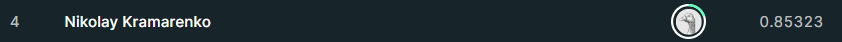

Ура, мы побили логрег)
Попробуем еще раз прогнать гридсерч.

In [51]:
params_grid = {'learning_rate': [0.05, 0.1, 0.2, 0.3],
        'depth': [2, 3, 4],
        'n_estimators': [200, 300, 400],
        'l2_leaf_reg': [1, 3, 5, 7, 9]}

In [57]:
cat3 = catboost.CatBoostClassifier(cat_features=cat_cols)
grid_search_result = cat3.grid_search(params_grid, 
                                       X=X, 
                                       y=y)


bestTest = 0.3768676582
bestIteration = 199

0:	loss: 0.3768677	best: 0.3768677 (0)	total: 1.79s	remaining: 5m 20s

bestTest = 0.3750753817
bestIteration = 199

1:	loss: 0.3750754	best: 0.3750754 (1)	total: 3.55s	remaining: 5m 15s

bestTest = 0.3766214125
bestIteration = 74

2:	loss: 0.3766214	best: 0.3750754 (1)	total: 5.5s	remaining: 5m 24s

bestTest = 0.3766585651
bestIteration = 42

3:	loss: 0.3766586	best: 0.3750754 (1)	total: 7.32s	remaining: 5m 22s

bestTest = 0.3765132179
bestIteration = 198

4:	loss: 0.3765132	best: 0.3750754 (1)	total: 8.98s	remaining: 5m 14s

bestTest = 0.3757950691
bestIteration = 174

5:	loss: 0.3757951	best: 0.3750754 (1)	total: 10.6s	remaining: 5m 6s

bestTest = 0.3760336398
bestIteration = 85

6:	loss: 0.3760336	best: 0.3750754 (1)	total: 12.4s	remaining: 5m 5s

bestTest = 0.3767351605
bestIteration = 74

7:	loss: 0.3767352	best: 0.3750754 (1)	total: 14.3s	remaining: 5m 6s

bestTest = 0.3772872894
bestIteration = 194

8:	loss: 0.3772873	best: 0.3750754

In [58]:
grid_search_result['params']

{'depth': 2, 'l2_leaf_reg': 9, 'iterations': 200, 'learning_rate': 0.1}

In [52]:
best_model2 = catboost.CatBoostClassifier(
    cat_features=cat_cols, n_estimators=200, depth=2, learning_rate=0.1, l2_leaf_reg=9)

In [53]:
best_model2.fit(X, y, silent=True);

In [54]:
submission = pd.read_csv('./submission.csv')
submission['Churn'] =  best_model2.predict_proba(test_data)[:, 1]
submission.to_csv('./my_submission.csv', index=False)

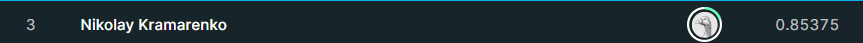

Лучший результат на тестовой выборке 0.85375,
параметры: n_estimators=200, depth=2, learning_rate=0.1, l2_leaf_reg=9

Дальнейшими манипуляциями удалось поднять до 0.85393, но это уже остается за рамками ДЗ.

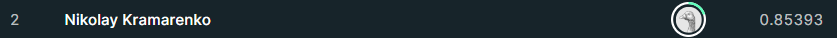